Sales Forecasting
#2. Univariate modeling
## 2-2. Exponential smoothing

In [33]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
data_path = "/content/drive/MyDrive/github_repo/time-series-study/data"

In [3]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [4]:
def plot_by_family(df:pd.DataFrame, store_id:int, categories:list=[], return_data:bool=False):
  if len(categories) == 0:
    df = df.loc[df.store_nbr==store_id, ][["date", "family", "sales"]]
  else:
    df = df.loc[(df.store_nbr==store_id) & (df.family.isin(categories)), ][["date", "family", "sales"]]
  df = pd.pivot(df, index=["date"], columns = "family", values = "sales").reset_index()

  fig = px.line(df, x="date", y=df.columns,
                hover_data={"date": "|%B %d, %Y"},
                title='sales time series')
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
  fig.show()
  return df if return_data else None

In [5]:
TARGET = "FROZEN FOODS" # ["LAWN AND GARDEN", "EGGS", "BEAUTY", "AUTOMOTIVE", "BOOKS", "FROZEN FOODS", "GROCERY I"]

In [6]:
train_df = plot_by_family(train, 44, [TARGET], True)

## 1) Simple Exponential Smoothing (단순지수평활법)

* 참고사이트: https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873

In [8]:
valid_ratio = 0.7

In [9]:
train_period = int(train_df.shape[0]*valid_ratio)
trains = train_df.iloc[:train_period]
valids = train_df.iloc[train_period:]

trains.shape, valids.shape

((1178, 2), (506, 2))

In [11]:
a = 0.8 # smoothing parameter

In [14]:
ses_fit = SimpleExpSmoothing(trains[TARGET])\
          .fit(smoothing_level=a, optimized=False, use_brute=True)

In [15]:
ses_preds = ses_fit.forecast(valids.shape[0])
ses_preds.shape

(506,)

In [49]:
print(f'MAE = {mean_absolute_error(valids[TARGET], ses_preds)}')
print(f'MSE = {mean_squared_error(valids[TARGET], ses_preds)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids[TARGET], ses_preds))}')

MAE = 224.62410648803288
MSE = 357801.33805046947
RMSE = 598.1649756133081


* SES의 특성 그대로 flat한 예측값 확인
  - SES는 h step의 미래의 값을 모두 동일한 값으로 예측함

<Axes: >

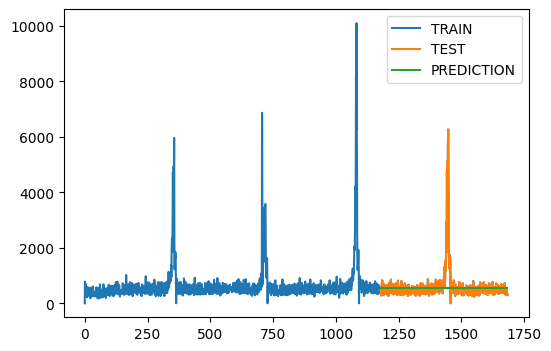

In [17]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
ses_preds.plot(legend=True, label='PREDICTION')

<Axes: >

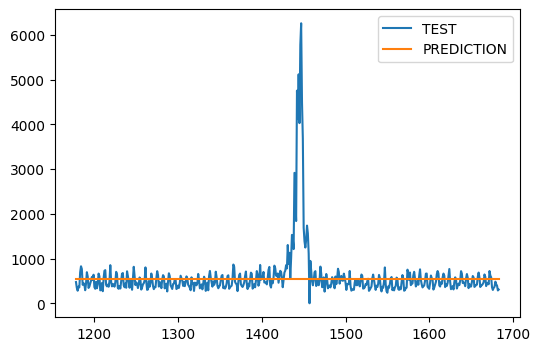

In [18]:
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
ses_preds.plot(legend=True, label='PREDICTION')

<Axes: >

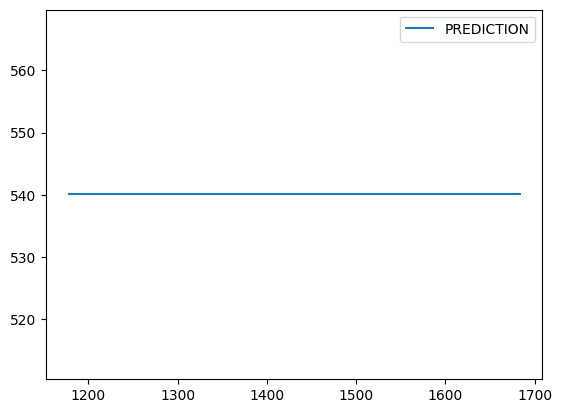

In [32]:
ses_preds.plot(legend=True, label='PREDICTION')

## 2) Holt의 추세기법

In [27]:
trend_fit = ExponentialSmoothing(trains[TARGET], trend='add').fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [22]:
trend_preds = trend_fit.forecast(valids.shape[0])
trend_preds.shape

(506,)

In [48]:
print(f'MAE = {mean_absolute_error(valids[TARGET], trend_preds)}')
print(f'MSE = {mean_squared_error(valids[TARGET], trend_preds)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids[TARGET], trend_preds))}')

MAE = 233.4843365020923
MSE = 356329.5473869593
RMSE = 596.9334530640407


* SES와 다르게 예측값의 추세가 존재하지만, 해당 데이터 자체가 추세보단 계절성이 강한 특징이 있고 이를 반영하지 못하고 있음

<Axes: >

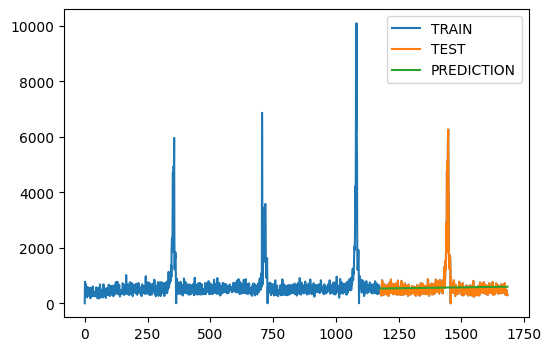

In [23]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST', figsize=(6,4))
trend_preds.plot(legend=True, label='PREDICTION')

<Axes: >

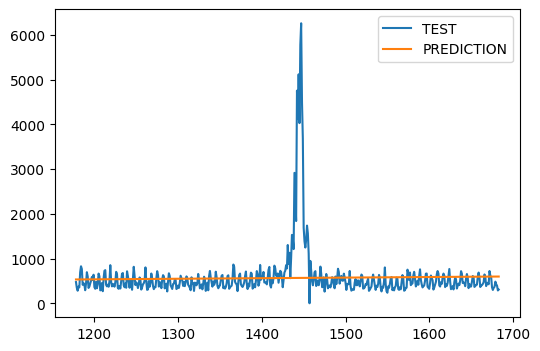

In [25]:
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
trend_preds.plot(legend=True, label='PREDICTION')

<Axes: >

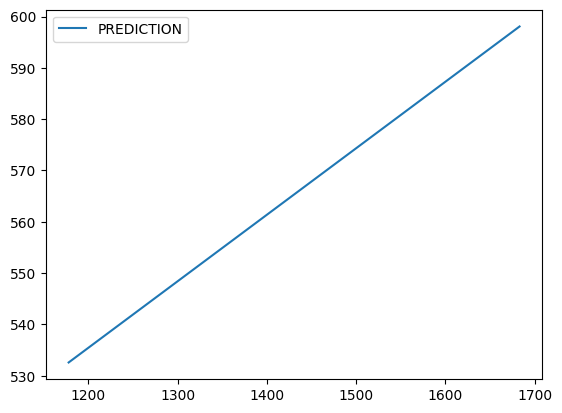

In [31]:
trend_preds.plot(legend=True, label='PREDICTION')

## 3) Holt-Winters Seasonal Method

In [28]:
hw_fit = ExponentialSmoothing(
    trains[TARGET], trend='add', seasonal='add', seasonal_periods=365
    ).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [29]:
hw_preds = hw_fit.forecast(valids.shape[0])
hw_preds.shape

(506,)

In [47]:
print(f'MAE = {mean_absolute_error(valids[TARGET], hw_preds)}')
print(f'MSE = {mean_squared_error(valids[TARGET], hw_preds)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids[TARGET], hw_preds))}')

MAE = 280.58116751206575
MSE = 181785.5640455715
RMSE = 426.3631832670024


* 계절성 반영으로 검증셋의 peak을 어느정도 예측하였고, 성능 지표도 이전 방법보다 개선됨
* 다만 추세 반영으로 인해 우측으로 갈수록 예측값이 증가하는 형태가 보임 
* 따라서 감쇠추세 (damped trend) 고려할 필요가 있어보임

<Axes: >

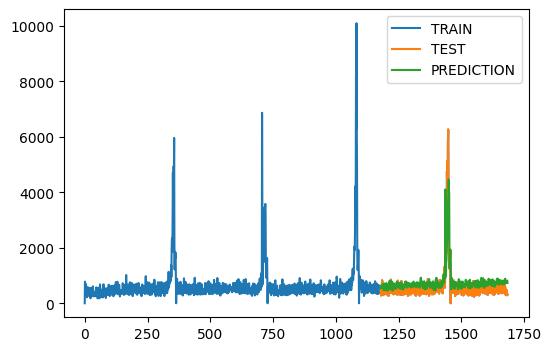

In [30]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
hw_preds.plot(legend=True, label='PREDICTION')

<Axes: >

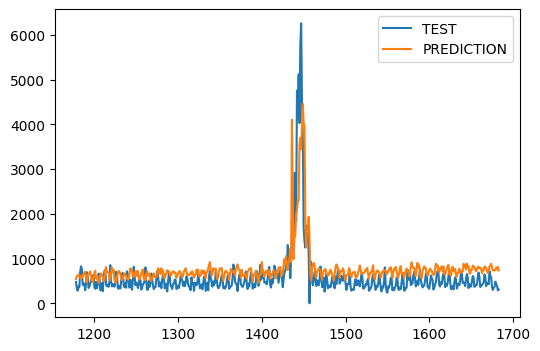

In [40]:
valids[TARGET].plot(legend=True, label='TEST', figsize=(6,4))
hw_preds.plot(legend=True, label='PREDICTION')

## 4) Holt-Winters seasonal method with damped trend

In [41]:
hwdt_fit = ExponentialSmoothing(
    trains[TARGET], trend='add', seasonal='add', seasonal_periods=365, damped_trend=True
    ).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [42]:
hwdt_preds = hwdt_fit.forecast(valids.shape[0])
hwdt_preds.shape

(506,)

In [46]:
print(f'MAE = {mean_absolute_error(valids[TARGET], hwdt_preds)}')
print(f'MSE = {mean_squared_error(valids[TARGET], hwdt_preds)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids[TARGET], hwdt_preds))}')

MAE = 229.8347903627959
MSE = 158152.2467301782
RMSE = 397.6836012839581


* 감쇠추세 (damped trend) 반영을 통해 기존 holt-winters방법 보다 성능지표 개선이 되었으며, 예측값의 추세가 기존보다 줄어들어 보다 예측성능이 좋아짐

<Axes: >

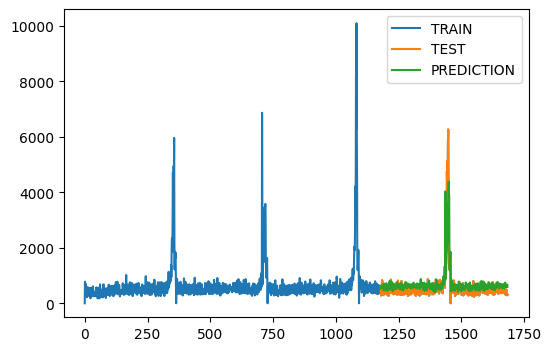

In [44]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
hwdt_preds.plot(legend=True, label='PREDICTION')

<Axes: >

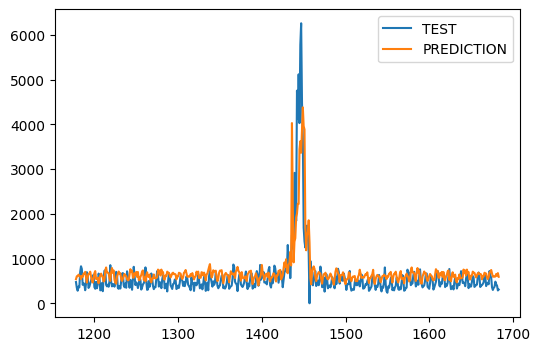

In [45]:
valids[TARGET].plot(legend=True, label='TEST', figsize=(6,4))
hwdt_preds.plot(legend=True, label='PREDICTION')